<a href="https://colab.research.google.com/github/LDJWJ/NLP_In_Action/blob/master/01_XLnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### XLNet 시작

#### colab에서 시작

<a href="https://colab.research.google.com/github/LDJWJ/NLP_In_Action/blob/master/01_XLnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* REF : https://github.com/billpku/NLP_In_Action 소스 코드 참조

In [0]:
import pandas as pd
import numpy as np

### 01. 데이터 불러오기(Load data)

In [0]:
data_path = "data/"
filename = "text_classification_dataset.csv"
df = pd.read_csv(data_path+filename, sep=",",
                 encoding='utf-8', 
                 names=['labels', 'texts'])


In [125]:
df

,labels,texts
0,0,"god is great , the movie's not ."
1,0,. . . the whole thing succeeded only in making...
2,1,"light the candles , bring out the cake and don..."
3,1,"the story may not be new , but australian dire..."
4,1,you live the mood rather than savour the story .
...,...,...
10657,0,"a tough go , but leigh's depth and rigor , and..."
10658,1,worth a look by those on both sides of the iss...
10659,0,pap invested in undergraduate doubling subtext...
10660,1,"there's absolutely no reason why blue crush , ..."


In [126]:
### 데이터 살펴보기
print(df.columns)  # 컬럼명

Index(['labels', 'texts'], dtype='object')


In [127]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10662 entries, 0 to 10661
Data columns (total 2 columns):
labels    10662 non-null int64
texts     10662 non-null object
dtypes: int64(1), object(1)
memory usage: 166.7+ KB
None


In [0]:
import seaborn as sns

In [129]:
print(df.labels.unique())         # 유일한 값 출력
print(df.labels.value_counts() )  # 값 목록 출력

[0 1]
1    5331
0    5331
Name: labels, dtype: int64


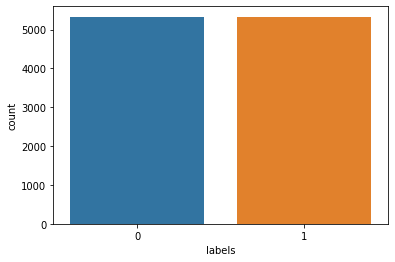

In [130]:
sns.countplot(x=df.labels)

### 데이터 처리
  * Token embedding (토큰 임베딩)
  * Mask word embedding (마스크 워드 임베딩)
  * Segmentation embedding(세그멘테이션)

* XLNet에서의 임베딩 데이터 처리는 Bert와 다르다.
  * sentencepiece 로 텍스트 토크나이저를 한다
    * \<sep>, \<cls>를 추가.
    * 임베딩을 위한 pad mask

# transformer 설치
 * 설치가 되어 있지 않다면 설치한다.
 * !pip install transformers

In [0]:
# pip install transformers

In [134]:
# Check library version
!pip list | grep -E 'transformers|torch|Keras'

Keras                    2.2.5          
Keras-Applications       1.0.8          
Keras-Preprocessing      1.1.0          
torch                    1.4.0          
torchsummary             1.5.1          
torchtext                0.3.1          
torchvision              0.5.0          
transformers             2.5.1          


* 개발 환경
  * Keras 2.2.5
  * torch 1.4.0
  * transformers 2.5.1

In [0]:
import torch
from tqdm import tqdm,trange
from transformers import (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer)

### 문장을 얻기(Get sentence data)

In [137]:
sentences = df.texts.to_list() 
print(type(sentences))
print(sentences[0:5])

<class 'list'>
["god is great , the movie's not .", '. . . the whole thing succeeded only in making me groggy .', "light the candles , bring out the cake and don't fret about the calories because there's precious little substance in birthday girl -- it's simply , and surprisingly , a nice , light treat .", 'the story may not be new , but australian director john polson , making his american feature debut , jazzes it up adroitly .', 'you live the mood rather than savour the story .']


In [138]:
### labels을 얻기(Get tag labels data)
labels = df.labels.to_list()
print(labels[0:5])

[0, 0, 1, 1, 1]


In [139]:
# Set a dict for mapping id to tag name
#tag2idx = {t: i for i, t in enumerate(tags_vals)}

### 학습을 위한 인덱스를 태그 이름으로 만들기
# 0:부정, 1:긍정
tag2idx = {'0':0, '1':1}
tag2idx

{'0': 0, '1': 1}

In [140]:
# Mapping index to name
tag2name={tag2idx[key] : key for key in tag2idx.keys()}
tag2name

{0: '0', 1: '1'}

### 학습용 데이터 만들기(Make tranning data)
 * gpu 환경
 * tokenizer를 가져와 tokenize하기
 * 토큰 임베딩, 마스크 워드 임베딩, 분할 임베딩 지정
 * 학습용, 평가용 나누기

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [142]:
print(device)
print(n_gpu)

cuda
1


### Tokenizer(토크나이저) 가져오기
  * pip install sentencepiece 실행

In [0]:
# pip install sentencepiece

In [0]:
# Manual define vocabulary address, 
# model 다운로드
# !wget "https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-spiece.model"

In [147]:
!ls -l

total 1572
drwxr-xr-x 2 root root   4096 Mar 13 08:51 data
drwxr-xr-x 3 root root   4096 Mar 13 09:50 models
drwxr-xr-x 1 root root   4096 Mar  3 18:11 sample_data
-rw-r--r-- 1 root root 798011 Jul 16  2019 xlnet-base-cased-spiece.model
-rw-r--r-- 1 root root 798011 Jul 16  2019 xlnet-base-cased-spiece.model.1


In [0]:
vocabulary = 'xlnet-base-cased-spiece.model'

In [0]:
# 문장의 길이(Len of the sentence must be the same as the training model)
# * 모델의 최대 (See model's 'max_position_embeddings' = 512)
max_len  = 64

In [150]:
# With cased model, 
#   do_lower_case = False  # 소문자.
tokenizer = XLNetTokenizer(vocab_file=vocabulary,do_lower_case=False)
tokenizer

### 임베딩
 * token id embedding
 * mask embedding
 * segment embedding

* 데이터 절차는 버트와 크게 다르다

In [0]:
max_len  = 64

full_input_ids = []
full_input_masks = []
full_segment_ids = []

SEG_ID_A   = 0
SEG_ID_B   = 1
SEG_ID_CLS = 2
SEG_ID_SEP = 3
SEG_ID_PAD = 4

In [0]:
UNK_ID = tokenizer.encode("<unk>")[0]
CLS_ID = tokenizer.encode("<cls>")[0]
SEP_ID = tokenizer.encode("<sep>")[0]
MASK_ID = tokenizer.encode("<mask>")[0]
EOD_ID = tokenizer.encode("<eod>")[0]

In [154]:
for i,sentence in enumerate(sentences):
    # Tokenize sentence to token id list
    tokens_a = tokenizer.encode(sentence)
    
    # Trim the len of text
    if(len(tokens_a)>max_len-2):
        tokens_a = tokens_a[:max_len-2]
        
    tokens = []
    segment_ids = []
    
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(SEG_ID_A)
        
    # Add <sep> token 
    tokens.append(SEP_ID)
    segment_ids.append(SEG_ID_A)
    
    
    # Add <cls> token
    tokens.append(CLS_ID)
    segment_ids.append(SEG_ID_CLS)
    
    input_ids = tokens
    
    # The mask has 0 for real tokens and 1 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [0] * len(input_ids)

    # Zero-pad up to the sequence length at fornt
    if len(input_ids) < max_len:
        delta_len = max_len - len(input_ids)
        input_ids = [0] * delta_len + input_ids
        input_mask = [1] * delta_len + input_mask
        segment_ids = [SEG_ID_PAD] * delta_len + segment_ids

    assert len(input_ids) == max_len
    assert len(input_mask) == max_len
    assert len(segment_ids) == max_len
    
    full_input_ids.append(input_ids)
    full_input_masks.append(input_mask)
    full_segment_ids.append(segment_ids)
    
    if 3 > i:
        print("No.:%d"%(i))
        print("sentence: %s"%(sentence))
        print("input_ids:%s"%(input_ids))
        print("attention_masks:%s"%(input_mask))
        print("segment_ids:%s"%(segment_ids))
        print("\n")

No.:0
sentence: god is great , the movie's not .
input_ids:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7290, 27, 312, 17, 19, 18, 1432, 26, 23, 50, 17, 9, 4, 3, 7739, 7739]
attention_masks:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
segment_ids:[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]


No.:1
sentence: . . . the whole thing succeeded only in making me groggy .
input_ids:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 9, 17, 9, 17, 9, 18, 856, 554, 5741, 114, 25, 441, 110, 17, 7059, 13006, 17, 9, 4, 3, 7739, 7739]

### label embedding 을 설정

In [155]:
# Make label into id
tags = [tag2idx[str(lab)] for lab in labels]
print(tags[0:5])

[0, 0, 1, 1, 1]


### 데이터 나누기(학습용 vs 평가용)
 * 70%(training), 30%(validation) 평가용

In [156]:
print( type(full_input_ids) )
print(full_input_ids[0])
print(full_input_ids[1])
print(len( full_input_ids[0]) )
print(len( full_input_ids ) )

print( type(tags) )
print(tags[0:5])
print(len( tags) )  # 10662

print( type(full_input_masks) )
print(full_input_masks[0])
print(full_input_masks[1])
print(len( full_input_masks[0]) )  # 64
print(len( full_input_masks) )  # 10662

print( type(full_segment_ids) )
print(full_segment_ids[0])
print(full_segment_ids[1])
print(len( full_segment_ids[0]) )  # 64
print(len( full_segment_ids) )  # 10662

<class 'list'>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7290, 27, 312, 17, 19, 18, 1432, 26, 23, 50, 17, 9, 4, 3, 7739, 7739]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 9, 17, 9, 17, 9, 18, 856, 554, 5741, 114, 25, 441, 110, 17, 7059, 13006, 17, 9, 4, 3, 7739, 7739]
64
10662
<class 'list'>
[0, 0, 1, 1, 1]
10662
<class 'list'>
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
64
10662
<class 'list'>
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [0]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [0]:
# train_test_split를 이용하여 학습용와 훈련용ㅇ로 나누어준다.
tr_inputs, val_inputs, tr_tags, val_tags,tr_masks, val_masks,tr_segs, val_segs = train_test_split(full_input_ids, 
                                                                                                  tags,
                                                                                                  full_input_masks,
                                                                                                  full_segment_ids, 
                                                                                          random_state=4, test_size=0.3)

In [159]:
len(tr_inputs),len(val_inputs),len(tr_segs),len(val_segs)

(7463, 3199, 7463, 3199)

### 데이터을 텐서로 변환
  * tensor.to(device)으로 변경하는 것은 GPU 메모리 부족이 발생
    * 추천안함.
  * torch.tensor() : 값 복사(value copy)를 사용하여 새로운 텐서 자료형 인스턴스 생성
    * torch.as_tensor(), torch.from_numpy()

In [0]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
tr_segs = torch.tensor(tr_segs)
val_segs = torch.tensor(val_segs)

### 데이터를 데이터 로드에 넣는다.
  * put data into data loader

In [0]:
batch_num = 32

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [0]:
# Set token embedding, 
# attention embedding, 
# segment embedding
train_data = TensorDataset(tr_inputs, tr_masks,tr_segs, tr_tags)
train_sampler = RandomSampler(train_data)

# Drop last can make batch training better for the last one
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_num,drop_last=True)

valid_data = TensorDataset(val_inputs, val_masks,val_segs, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_num)

### 모델 학습
 * Load XLNet model

In [0]:
# contain config(txt) and weight(bin) files
model_file_address = 'xlnet-base-cased'

In [0]:
# from_pretrained()함수를 사용하여 config와 weight를 가져온다.
# Recommand download the model before using
# 모델 :  "https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-pytorch_model.bin"
# 모델 : "https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json" 
model = XLNetForSequenceClassification.from_pretrained(model_file_address,num_labels=len(tag2idx))

In [166]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [0]:
# Set model to GPU,if you are using GPU machine
model.to(device);

In [0]:
# 만약 멀티 GPU를 지원하는 것을 더한다면
if n_gpu >1:
    model = torch.nn.DataParallel(model)

In [0]:
# epoch를 지정,  max_grad_norm을 지정
epochs = 5
max_grad_norm = 1.0

In [0]:
import math

In [0]:
# 총 step을 계산
num_train_optimization_steps = int( math.ceil(len(tr_inputs) / batch_num) / 1) * epochs

In [0]:
# fine tuning 방법 지정

In [0]:
# True: 모든 층을 대상으로 한다(fine tuning all the layers)
# False:  classifier layers() 만을 fine tuning한다.
# pytorch_transformer의 XLNet에서는 classifier layers의 층을 포함하지 않기에 
# 여기서 값을 True 로 설정
# FULL_FINETUNING = True need to set True
FULL_FINETUNING = True

In [0]:
from torch.optim import Adam

In [0]:
if FULL_FINETUNING:
    # Fine tune model all layer parameters
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    # Only fine tune classifier parameters
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [0]:
### Fine Tunning 

In [0]:
# TRAIN loop
model.train();

In [178]:
epochs

5

In [179]:
trange(epochs,desc="Epoch")


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

In [180]:
%%time

print("***** 학습을 시작 *****")
print("  데이터의 수 = %d"%(len(tr_inputs)))
print("  Batch size = %d"%(batch_num))
print("  Steps 수 = %d"%(num_train_optimization_steps))
for _ in trange(epochs,desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):

        # gpu 
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_segs,b_labels = batch
        
        # 순전파
        # forward pass
        outputs = model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
        loss, logits = outputs[:2]
        if n_gpu>1:
            # When multi gpu, average it
            loss = loss.mean()
        
        # 역전파
        # backward pass
        loss.backward()
        
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        optimizer.zero_grad()
        
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
        



Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

***** 학습을 시작 *****
  데이터의 수 = 7463
  Batch size = 32
  Steps 수 = 1170


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:  20%|██        | 1/5 [01:10<04:43, 70.88s/it]

Train loss: 0.4500386277173722




Epoch:  40%|████      | 2/5 [02:21<03:32, 70.86s/it]

Train loss: 0.26761485700187765




Epoch:  60%|██████    | 3/5 [03:32<02:21, 70.85s/it]

Train loss: 0.1627467559418709




Epoch:  80%|████████  | 4/5 [04:43<01:10, 70.84s/it]

Train loss: 0.11386690981877975




Epoch: 100%|██████████| 5/5 [05:53<00:00, 70.74s/it]



Train loss: 0.07443445211460278
CPU times: user 4min 29s, sys: 1min 23s, total: 5min 52s
Wall time: 5min 53s


### 모델 저장

In [0]:
import os

In [0]:
xlnet_out_address = 'models/xlnet_out_model/tc02'

# 디렉터리 생성
if not os.path.exists(xlnet_out_address):
        os.makedirs(xlnet_out_address)

In [183]:
# 학습 모델, configuration and tokenizer 저장
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
type(model_to_save)

transformers.modeling_xlnet.XLNetForSequenceClassification

In [0]:
# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(xlnet_out_address, "pytorch_model.bin")
output_config_file = os.path.join(xlnet_out_address, "config.json")

In [185]:
# 파일로부터 모델 저장
torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(xlnet_out_address)

('models/xlnet_out_model/tc02/spiece.model',)

### 모델 불러오기(Load Model)

In [186]:
xlnet_out_address

'models/xlnet_out_model/tc02'

In [187]:
model = XLNetForSequenceClassification.from_pretrained(xlnet_out_address, num_labels=len(tag2idx))
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [0]:
# Set model to GPU
model.to(device);

In [0]:
if n_gpu >1:
    model = torch.nn.DataParallel(model)

### 모델 평가(Eval Model)

In [0]:
# Evalue loop
model.eval();

In [0]:
# Set acc funtion
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

In [192]:
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

y_true = []
y_predict = []
print("***** Running evaluation *****")
print("  Num examples ={}".format(len(val_inputs)))
print("  Batch size = {}".format(batch_num))
for step, batch in enumerate(valid_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_segs,b_labels = batch
    
    with torch.no_grad():
        outputs = model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
        tmp_eval_loss, logits = outputs[:2]
    
    # Get textclassification predict result
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = accuracy(logits, label_ids)
#     print(tmp_eval_accuracy)
#     print(np.argmax(logits, axis=1))
#     print(label_ids)
    
    # Save predict and real label reuslt for analyze
    for predict in np.argmax(logits, axis=1):
        y_predict.append(predict)
        
    for real_result in label_ids.tolist():
        y_true.append(real_result)

    
    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy
   
    nb_eval_steps += 1
    
    
eval_loss = eval_loss / nb_eval_steps
eval_accuracy = eval_accuracy / len(val_inputs)
loss = tr_loss/nb_tr_steps 
result = {'eval_loss': eval_loss,
                  'eval_accuracy': eval_accuracy,
                  'loss': loss}
report = classification_report(y_pred=np.array(y_predict),y_true=np.array(y_true))

# Save the report into file
output_eval_file = os.path.join(xlnet_out_address, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    print("***** Eval results *****")
    for key in sorted(result.keys()):
        print("  %s = %s"%(key, str(result[key])))
        writer.write("%s = %s\n" % (key, str(result[key])))
        
    print(report)
    writer.write("\n\n")  
    writer.write(report)

***** Running evaluation *****
  Num examples =3199
  Batch size = 32


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


***** Eval results *****
  eval_accuracy = 0.883401062832135
  eval_loss = 0.5842045833915472
  loss = 0.07443445211460278
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1586
           1       0.89      0.87      0.88      1613

    accuracy                           0.88      3199
   macro avg       0.88      0.88      0.88      3199
weighted avg       0.88      0.88      0.88      3199



### REF 
 *  https://github.com/billpku/NLP_In_Action